# Embedding-Based Data Heterogeneity for Federated Learning

## Overview

This notebook implements a **semantic-aware data partitioning strategy** for Federated Learning (FL) using DINOv2 vision embeddings. Unlike random or label-based partitioning, this approach:

1. **Extracts scene-level representations** using DINOv2's CLS token (captures global image semantics)
2. **Discovers natural scene clusters** via K-Means (groups visually similar driving scenes)
3. **Creates heterogeneous client splits** using Dirichlet distribution (controls non-IID degree via α parameter)

### Why This Matters for FL

In real-world FL for autonomous driving, different cities/regions have different visual characteristics (weather, architecture, road layouts). This pipeline **simulates realistic data heterogeneity** by grouping semantically similar images and distributing them unevenly across clients.

### Key Parameter: Dirichlet α

- **α → 0** (e.g., 0.1): Extreme heterogeneity - each client specializes in few scene types
- **α → ∞** (e.g., 100): Near IID - all clients have similar data distributions

---

## Section 1: Environment Setup

In [1]:
# Cell 1: Clone Repository
!git clone https://github.com/YoussifKhaled/dinov2.git
%cd dinov2

Cloning into 'dinov2'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 550 (delta 11), reused 34 (delta 11), pack-reused 513 (from 2)
Receiving objects: 100% (550/550), 1.44 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (257/257), done.
/kaggle/working/dinov2


In [2]:
# Uninstall Kaggle's broken PyTorch
!pip uninstall -y torch torchvision torchaudio

# Install from our requirements.txt (has correct versions)
!pip install -r dinov2/fl/requirements.txt

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 412.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 105.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 68.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━

In [3]:
%cd /kaggle/working/dinov2

import torch
import torchvision
import os

print("=" * 50)
print("ENVIRONMENT CHECK")
print("=" * 50)
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Check dataset
BASE_PATH = "/kaggle/input/cityscapes-fine-dataset"  # ← CHANGE IF DIFFERENT
print(f"\nDataset path: {BASE_PATH}")
print(f"Dataset exists: {os.path.exists(BASE_PATH)}")
if os.path.exists(BASE_PATH):
    print(f"Contents: {os.listdir(BASE_PATH)}")
else:
    print("ERROR: Dataset not found! Check your data path.")
    print("Go to: + Add Data → find your Cityscapes dataset")
    print("Then update BASE_PATH above")
print("=" * 50)

/kaggle/working/dinov2
ENVIRONMENT CHECK
PyTorch: 2.1.0+cu118
Torchvision: 0.16.0+cu118
CUDA available: True
GPU: Tesla P100-PCIE-16GB

Dataset path: /kaggle/input/cityscapes-fine-dataset
Dataset exists: True
Contents: ['leftImg8bit', 'train_cityscapes.pkl', 'gtFine']


---

## Section 2: Run Pipeline

Run the 3 phases: Embedding Extraction → Clustering → Partitioning

In [4]:
# Phase 1: Extract DINOv2 Embeddings (~15-20 min on T4)
!python -m dinov2.fl.scripts.run_extraction \
    --dataset_list_file train_fine.txt \
    --base_path /kaggle/input/cityscapes-fine-dataset \
    --output_dir /kaggle/working/fl_outputs \
    --model_name dinov2_vitl14 \
    --batch_size 16

Phase 1: DINOv2 Embedding Extraction
Dataset list: train_fine.txt
Base path: /kaggle/input/cityscapes-fine-dataset
Model: dinov2_vitl14
Batch size: 16
Output: /kaggle/working/fl_outputs/embeddings.pth
Loading dataset from train_fine.txt
Loaded 2975 image paths from train_fine.txt
Loading dinov2_vitl14 from torch hub...
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/kaggle/working/dinov2/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/kaggle/working/dinov2/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/kaggle/working/dinov2/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.

In [5]:
# Phase 2: Cluster Embeddings (~1 min)
!python -m dinov2.fl.scripts.run_clustering \
    --output_dir /kaggle/working/fl_outputs \
    --n_clusters 16

Phase 2: K-Means Clustering
Embeddings: /kaggle/working/fl_outputs/embeddings.pth
Number of clusters: 16
Output: /kaggle/working/fl_outputs/clusters.pth
Loaded 2975 embeddings from /kaggle/working/fl_outputs/embeddings.pth
Clustering 2975 embeddings into 16 clusters...
Clustering complete. Inertia: 2723051.50
Cluster sizes: min=72, max=322, mean=185.9
Saving clusters to /kaggle/working/fl_outputs/clusters.pth

Clustering complete!
Clustered 2975 samples into 16 clusters
Cluster sizes: {0: 150, 1: 178, 2: 258, 3: 177, 4: 72, 5: 226, 6: 322, 7: 143, 8: 164, 9: 315, 10: 157, 11: 159, 12: 189, 13: 121, 14: 203, 15: 141}
Saved to: /kaggle/working/fl_outputs/clusters.pth


In [6]:
# Phase 3: Partition Data (α=0.5, ~seconds)
!python -m dinov2.fl.scripts.run_partitioning \
    --output_dir /kaggle/working/fl_outputs \
    --n_clients 10 \
    --alpha 0.5

Phase 3: Dirichlet Data Partitioning
Clusters: /kaggle/working/fl_outputs/clusters.pth
Number of clients: 10
Alpha (heterogeneity): 0.5
  - Low alpha (0.1): Highly non-IID
  - High alpha (100): Nearly IID
Output: /kaggle/working/fl_outputs/client_splits.pth
Loaded 2975 cluster assignments (16 clusters)
Partitioning 2975 samples across 10 clients
Alpha (heterogeneity): 0.5 (lower = more non-IID)

Partitioning complete:
  Total samples: 2975
  Samples per client: 125 - 419 (mean: 297.5, std: 93.6)

Saving client splits to /kaggle/working/fl_outputs/client_splits.pth

Partitioning complete!
Created splits for 10 clients
Total samples: 2975
Samples per client:
  Client 0: 125 samples from 13 clusters
  Client 1: 260 samples from 11 clusters
  Client 2: 330 samples from 15 clusters
  Client 3: 399 samples from 14 clusters
  Client 4: 201 samples from 14 clusters
  Client 5: 396 samples from 14 clusters
  Client 6: 419 samples from 10 clusters
  Client 7: 227 samples from 13 clusters
  Clien

---

## Section 3: Analysis & Visualization

This section provides comprehensive visualizations to understand each pipeline phase.

**What you'll see:**
- **3.1** - How DINOv2 represents Cityscapes images in embedding space
- **3.2** - How K-Means groups images into semantic clusters  
- **3.3** - How Dirichlet partitioning distributes data across FL clients
- **3.4** - How different α values affect heterogeneity

In [7]:
# Setup visualization environment
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Professional plot styling
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'font.family': 'sans-serif'
})

# Color palettes
CLUSTER_COLORS = plt.cm.tab20(np.linspace(0, 1, 20))
CLIENT_COLORS = plt.cm.Set3(np.linspace(0, 1, 12))

# Paths
OUTPUT_DIR = "/kaggle/working/fl_outputs"
BASE_PATH = "/kaggle/input/cityscapes-fine-dataset"

print("✓ Visualization environment ready")

✓ Visualization environment ready


### 3.1 Load Pipeline Outputs

First, we load all the data generated by the pipeline phases.

In [8]:
# ============================================================
# LOAD ALL PIPELINE OUTPUTS
# ============================================================

# Phase 1: Embeddings
embeddings_data = torch.load(f"{OUTPUT_DIR}/embeddings.pth")
embeddings = embeddings_data["embeddings"].numpy()
image_paths = embeddings_data["image_paths"]

# Phase 2: Clusters  
clusters_data = torch.load(f"{OUTPUT_DIR}/clusters.pth")
cluster_labels = clusters_data["cluster_labels"]
n_clusters = clusters_data.get("n_clusters", int(max(cluster_labels)) + 1)

# Phase 3: Client partitions
splits_data = torch.load(f"{OUTPUT_DIR}/client_splits.pth")
client_data = splits_data["client_data"]  # Dict: client_id -> list of sample indices
n_clients = splits_data["config"]["n_clients"]
alpha = splits_data["config"]["alpha"]

# Extract city names from paths (e.g., "frankfurt", "munster", etc.)
cities = [p.split("/")[-2] for p in image_paths]
unique_cities = sorted(set(cities))

# Print summary
print("=" * 60)
print("PIPELINE OUTPUT SUMMARY")
print("=" * 60)
print(f"  Total images:      {len(image_paths)}")
print(f"  Embedding dim:     {embeddings.shape[1]}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Number of clients:  {n_clients}")
print(f"  Dirichlet α:        {alpha}")
print(f"  Cities:             {', '.join(unique_cities)}")
print("=" * 60)

PIPELINE OUTPUT SUMMARY
  Total images:      2975
  Embedding dim:     1024
  Number of clusters: 16
  Number of clients:  10
  Dirichlet α:        0.5
  Cities:             aachen, bochum, bremen, cologne, darmstadt, dusseldorf, erfurt, hamburg, hanover, jena, krefeld, monchengladbach, strasbourg, stuttgart, tubingen, ulm, weimar, zurich


### 3.2 Embedding Space Analysis (Phase 1 Output)

**Purpose:** Visualize how DINOv2 represents Cityscapes images.

**What to look for:**
- Images from the same city may cluster together (city-specific visual patterns)
- OR images may mix across cities (shared visual semantics like "highway", "urban center")
- The embedding space structure reveals what DINOv2 "sees" as similar

Computing t-SNE projection (this takes ~1-2 minutes)...
✓ t-SNE complete


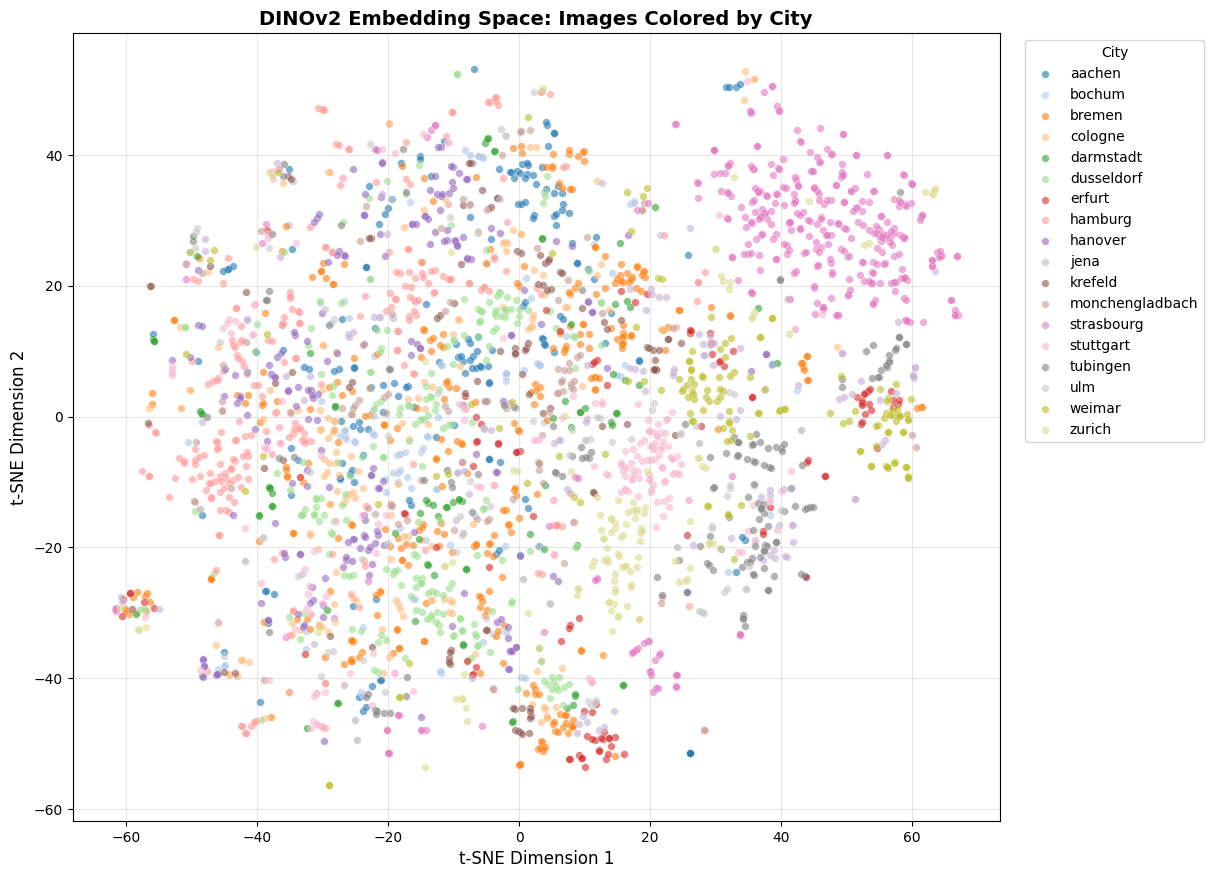


📊 INTERPRETATION:
   • If cities form separate clusters → location-specific visual patterns dominate
   • If cities overlap → DINOv2 captures scene semantics beyond geography
   • Mixed patterns suggest both factors matter


In [10]:
# ============================================================
# VISUALIZATION 1: t-SNE of Embedding Space (by City)
# ============================================================
# This shows how images from different cities are distributed
# in the learned representation space.

print("Computing t-SNE projection (this takes ~1-2 minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)
print("✓ t-SNE complete")

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each city with a distinct color
for i, city in enumerate(unique_cities):
    mask = [c == city for c in cities]
    ax.scatter(
        embeddings_2d[mask, 0], 
        embeddings_2d[mask, 1],
        c=[CLUSTER_COLORS[i % 20]],
        label=city,
        alpha=0.6,
        s=30,
        edgecolors='white',
        linewidth=0.3
    )

ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.set_title("DINOv2 Embedding Space: Images Colored by City", fontsize=14, fontweight='bold')
ax.legend(title="City", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/viz1_tsne_by_city.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("   • If cities form separate clusters → location-specific visual patterns dominate")
print("   • If cities overlap → DINOv2 captures scene semantics beyond geography")
print("   • Mixed patterns suggest both factors matter")

### 3.3 Clustering Analysis (Phase 2 Output)

**Purpose:** Understand what "scene types" K-Means discovered from the embeddings.

**What to look for:**
- Clusters should correspond to visually coherent scene categories
- Examples: urban dense, suburban, highway, residential, etc.
- Cluster sizes show the distribution of scene types in Cityscapes

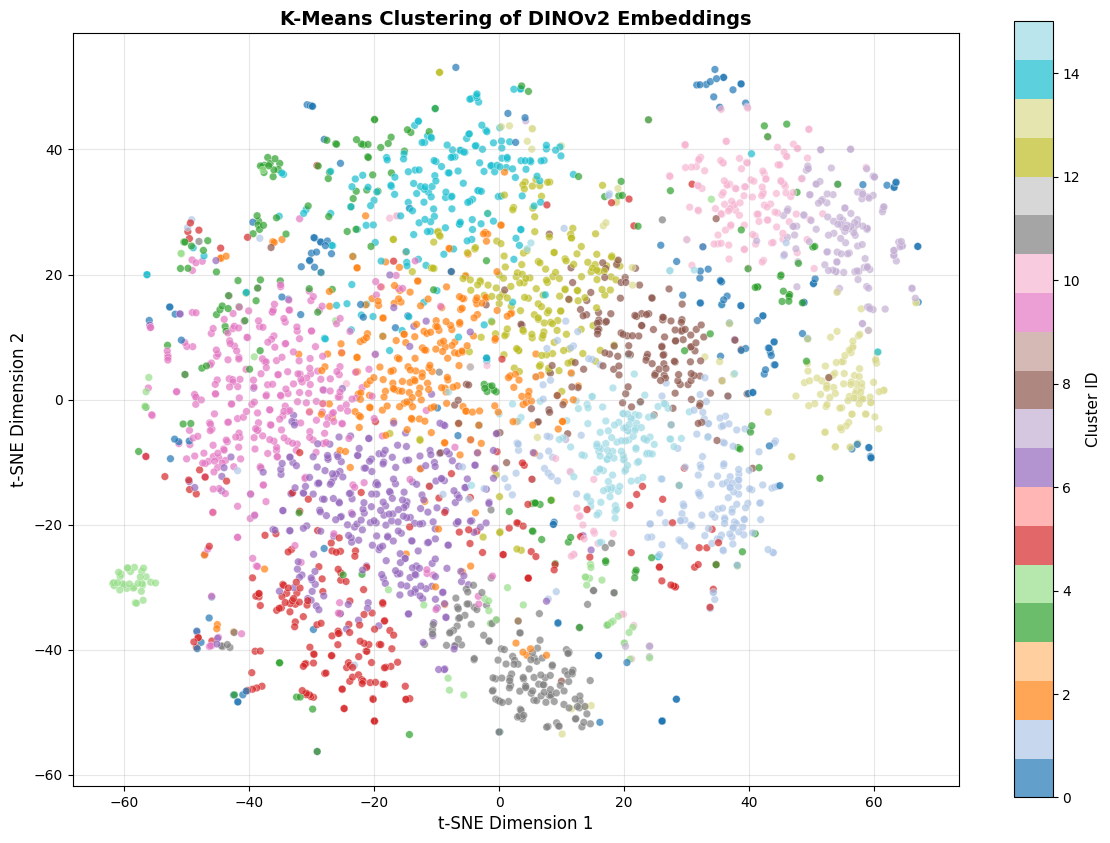


📊 INTERPRETATION:
   • Each color represents a discovered 'scene type'
   • Compact, well-separated clusters = clear semantic categories
   • Overlapping clusters = gradual transitions between scene types


In [11]:
# ============================================================
# VISUALIZATION 2: t-SNE Colored by Cluster Assignment
# ============================================================
# This shows how K-Means partitioned the embedding space.
# Each color = one cluster (scene type)

fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=cluster_labels,
    cmap='tab20',
    alpha=0.7,
    s=30,
    edgecolors='white',
    linewidth=0.3
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Cluster ID', fontsize=11)
cbar.set_ticks(range(0, n_clusters, max(1, n_clusters//8)))

ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.set_title("K-Means Clustering of DINOv2 Embeddings", fontsize=14, fontweight='bold')
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/viz2_tsne_by_cluster.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("   • Each color represents a discovered 'scene type'")
print("   • Compact, well-separated clusters = clear semantic categories")
print("   • Overlapping clusters = gradual transitions between scene types")

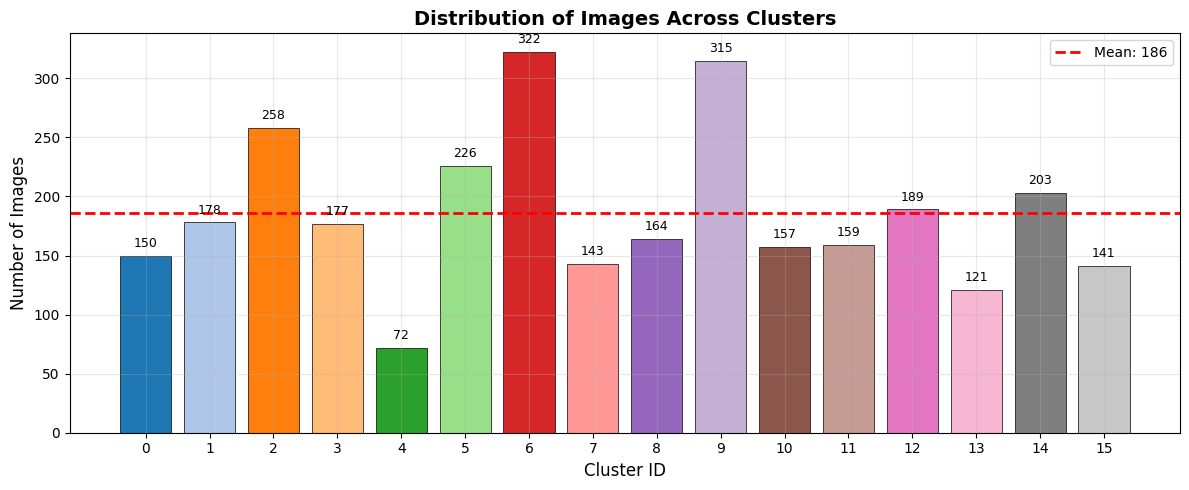


📊 INTERPRETATION:
   • Total images: 2975
   • Largest cluster: 322 images (Cluster 6)
   • Smallest cluster: 72 images (Cluster 4)
   • Uneven sizes are expected - some scene types are more common


In [12]:
# ============================================================
# VISUALIZATION 3: Cluster Size Distribution
# ============================================================
# Shows how many images belong to each cluster

cluster_counts = Counter(cluster_labels)
cluster_ids = list(range(n_clusters))
counts = [cluster_counts.get(i, 0) for i in cluster_ids]

fig, ax = plt.subplots(figsize=(12, 5))

bars = ax.bar(cluster_ids, counts, color=[CLUSTER_COLORS[i % 20] for i in cluster_ids], 
              edgecolor='black', linewidth=0.5)

# Add value labels on bars
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            str(count), ha='center', va='bottom', fontsize=9)

ax.axhline(y=np.mean(counts), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(counts):.0f}')

ax.set_xlabel("Cluster ID", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.set_title("Distribution of Images Across Clusters", fontsize=14, fontweight='bold')
ax.set_xticks(cluster_ids)
ax.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/viz3_cluster_sizes.png", dpi=150)
plt.show()

print("\n📊 INTERPRETATION:")
print(f"   • Total images: {sum(counts)}")
print(f"   • Largest cluster: {max(counts)} images (Cluster {counts.index(max(counts))})")
print(f"   • Smallest cluster: {min(counts)} images (Cluster {counts.index(min(counts))})")
print("   • Uneven sizes are expected - some scene types are more common")

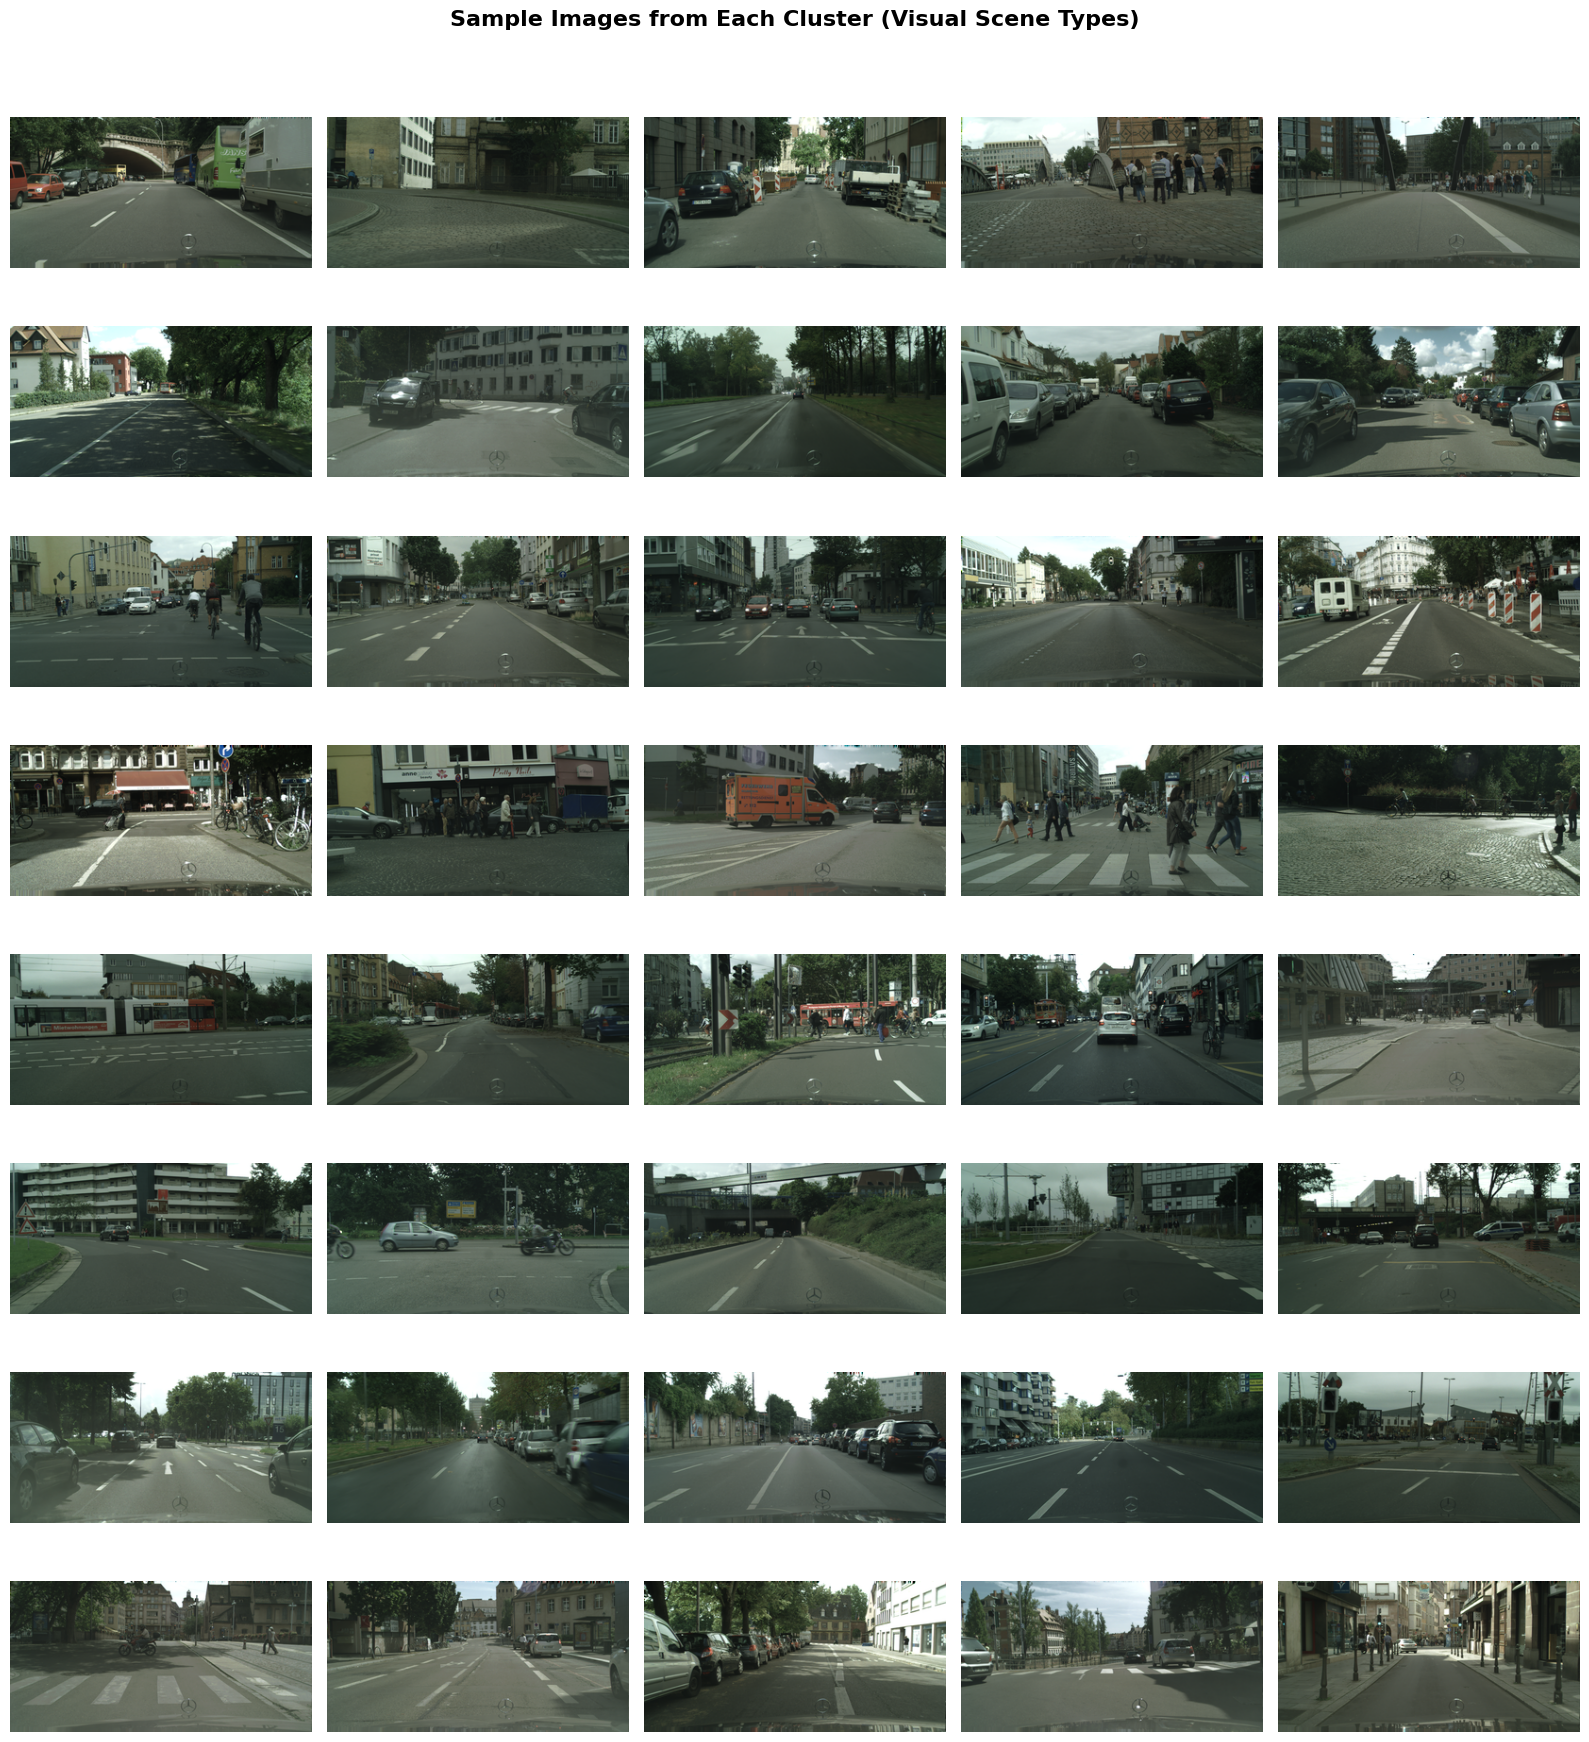


📊 INTERPRETATION:
   • Each row shows images from ONE cluster
   • Look for visual similarities within each row:
     - Similar road types (highway vs urban)
     - Similar building density
     - Similar weather/lighting conditions
     - Similar perspective (straight road vs intersection)


In [13]:
# ============================================================
# VISUALIZATION 4: Sample Images from Each Cluster
# ============================================================
# This reveals what visual patterns each cluster captures

def load_image(path, size=(320, 160)):
    """Load and resize image for display"""
    try:
        img = Image.open(path).convert("RGB")
        img = img.resize(size, Image.LANCZOS)
        return np.array(img)
    except:
        return np.zeros((size[1], size[0], 3), dtype=np.uint8)

# Show 5 samples from each cluster (or fewer clusters if too many)
n_clusters_to_show = min(n_clusters, 8)  # Limit for readability
n_samples = 5

fig, axes = plt.subplots(n_clusters_to_show, n_samples, figsize=(16, n_clusters_to_show * 2.2))

for cluster_id in range(n_clusters_to_show):
    # Get indices for this cluster
    indices = np.where(cluster_labels == cluster_id)[0]
    # Random sample
    np.random.seed(42 + cluster_id)
    sample_idx = np.random.choice(indices, min(n_samples, len(indices)), replace=False)
    
    for j, idx in enumerate(sample_idx):
        img = load_image(image_paths[idx])
        axes[cluster_id, j].imshow(img)
        axes[cluster_id, j].axis('off')
    
    # Add cluster label on the left
    axes[cluster_id, 0].set_ylabel(
        f"Cluster {cluster_id}\n({len(indices)} imgs)", 
        fontsize=11, rotation=0, ha='right', va='center', labelpad=60,
        fontweight='bold'
    )

fig.suptitle("Sample Images from Each Cluster (Visual Scene Types)", 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/viz4_cluster_samples.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("   • Each row shows images from ONE cluster")
print("   • Look for visual similarities within each row:")
print("     - Similar road types (highway vs urban)")
print("     - Similar building density")
print("     - Similar weather/lighting conditions")
print("     - Similar perspective (straight road vs intersection)")

### 3.4 Client Partition Analysis (Phase 3 Output)

**Purpose:** Understand how data is distributed across FL clients.

**What to look for:**
- With low α: Clients should "specialize" in certain clusters (non-IID)
- With high α: Clients should have similar cluster distributions (near IID)
- Sample count imbalance also affects FL convergence

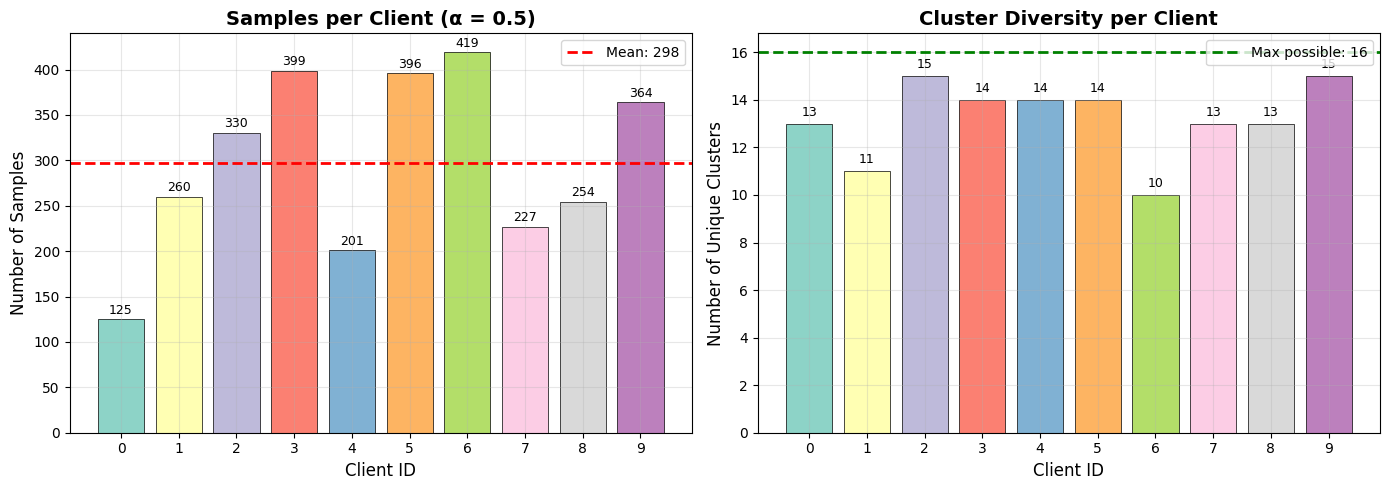


📊 INTERPRETATION:
   LEFT PLOT - Sample Balance:
   • Range: 125 to 419 samples
   • Std Dev: 93.6
   • High variance = unequal client workloads

   RIGHT PLOT - Data Diversity:
   • Range: 10 to 15 clusters per client
   • Lower numbers = more specialized clients (more non-IID)


In [14]:
# ============================================================
# VISUALIZATION 5: Client Data Distribution Overview
# ============================================================

stats = splits_data["statistics"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Samples per client
samples_per_client = [stats['samples_per_client'][i] for i in range(n_clients)]
colors = [CLIENT_COLORS[i % 12] for i in range(n_clients)]

bars = axes[0].bar(range(n_clients), samples_per_client, color=colors, 
                   edgecolor='black', linewidth=0.5)
axes[0].axhline(y=np.mean(samples_per_client), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(samples_per_client):.0f}')

for bar, count in zip(bars, samples_per_client):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
                 str(count), ha='center', va='bottom', fontsize=9)

axes[0].set_xlabel("Client ID", fontsize=12)
axes[0].set_ylabel("Number of Samples", fontsize=12)
axes[0].set_title(f"Samples per Client (α = {alpha})", fontsize=14, fontweight='bold')
axes[0].set_xticks(range(n_clients))
axes[0].legend()

# Right: Clusters per client (diversity)
clusters_per_client = [stats['clusters_per_client'][i] for i in range(n_clients)]
bars = axes[1].bar(range(n_clients), clusters_per_client, color=colors,
                   edgecolor='black', linewidth=0.5)
axes[1].axhline(y=n_clusters, color='green', linestyle='--', linewidth=2,
                label=f'Max possible: {n_clusters}')

for bar, count in zip(bars, clusters_per_client):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                 str(count), ha='center', va='bottom', fontsize=9)

axes[1].set_xlabel("Client ID", fontsize=12)
axes[1].set_ylabel("Number of Unique Clusters", fontsize=12)
axes[1].set_title("Cluster Diversity per Client", fontsize=14, fontweight='bold')
axes[1].set_xticks(range(n_clients))
axes[1].legend()

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/viz5_client_overview.png", dpi=150)
plt.show()

print("\n📊 INTERPRETATION:")
print(f"   LEFT PLOT - Sample Balance:")
print(f"   • Range: {min(samples_per_client)} to {max(samples_per_client)} samples")
print(f"   • Std Dev: {np.std(samples_per_client):.1f}")
print(f"   • High variance = unequal client workloads")
print(f"\n   RIGHT PLOT - Data Diversity:")
print(f"   • Range: {min(clusters_per_client)} to {max(clusters_per_client)} clusters per client")
print(f"   • Lower numbers = more specialized clients (more non-IID)")

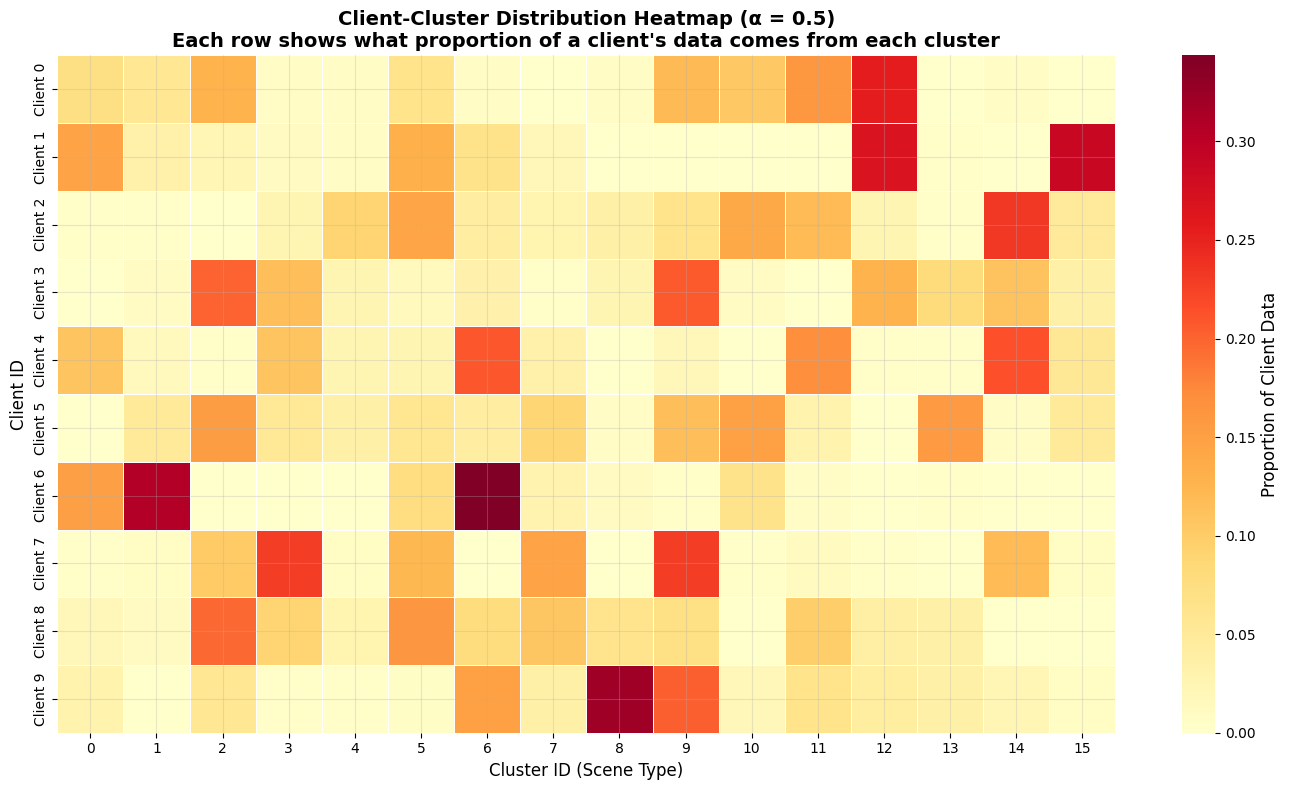


📊 INTERPRETATION:
   • Each ROW = one client's data composition
   • Each COLUMN = one cluster (scene type)
   • Dark cells = client has LOTS of that scene type
   • Light cells = client has LITTLE of that scene type

   NON-IID PATTERNS TO LOOK FOR:
   • 'Striped' rows (few dark cells) = specialized clients
   • 'Uniform' rows = diverse clients with IID-like data
   • With α = 0.5: expect specialized clients


In [15]:
# ============================================================
# VISUALIZATION 6: Client-Cluster Heatmap (THE KEY VISUALIZATION)
# ============================================================
# This is the most important visualization - it shows WHAT data
# each client has in terms of scene types.

# Build the client-cluster matrix
client_cluster_matrix = np.zeros((n_clients, n_clusters))
for cid in range(n_clients):
    for idx in client_data[cid]:
        client_cluster_matrix[cid, cluster_labels[idx]] += 1

# Normalize by client (each row sums to 1) - shows PROPORTION
client_cluster_norm = client_cluster_matrix / client_cluster_matrix.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap
sns.heatmap(
    client_cluster_norm,
    annot=False,
    cmap='YlOrRd',
    ax=ax,
    cbar_kws={'label': 'Proportion of Client Data'},
    xticklabels=[f'{i}' for i in range(n_clusters)],
    yticklabels=[f'Client {i}' for i in range(n_clients)],
    linewidths=0.5,
    linecolor='white'
)

ax.set_xlabel("Cluster ID (Scene Type)", fontsize=12)
ax.set_ylabel("Client ID", fontsize=12)
ax.set_title(f"Client-Cluster Distribution Heatmap (α = {alpha})\nEach row shows what proportion of a client's data comes from each cluster", 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/viz6_client_cluster_heatmap.png", dpi=150)
plt.show()

print("\n📊 INTERPRETATION:")
print("   • Each ROW = one client's data composition")
print("   • Each COLUMN = one cluster (scene type)")
print("   • Dark cells = client has LOTS of that scene type")
print("   • Light cells = client has LITTLE of that scene type")
print("")
print("   NON-IID PATTERNS TO LOOK FOR:")
print("   • 'Striped' rows (few dark cells) = specialized clients")
print("   • 'Uniform' rows = diverse clients with IID-like data")
print(f"   • With α = {alpha}: expect {'specialized' if alpha < 1 else 'diverse'} clients")

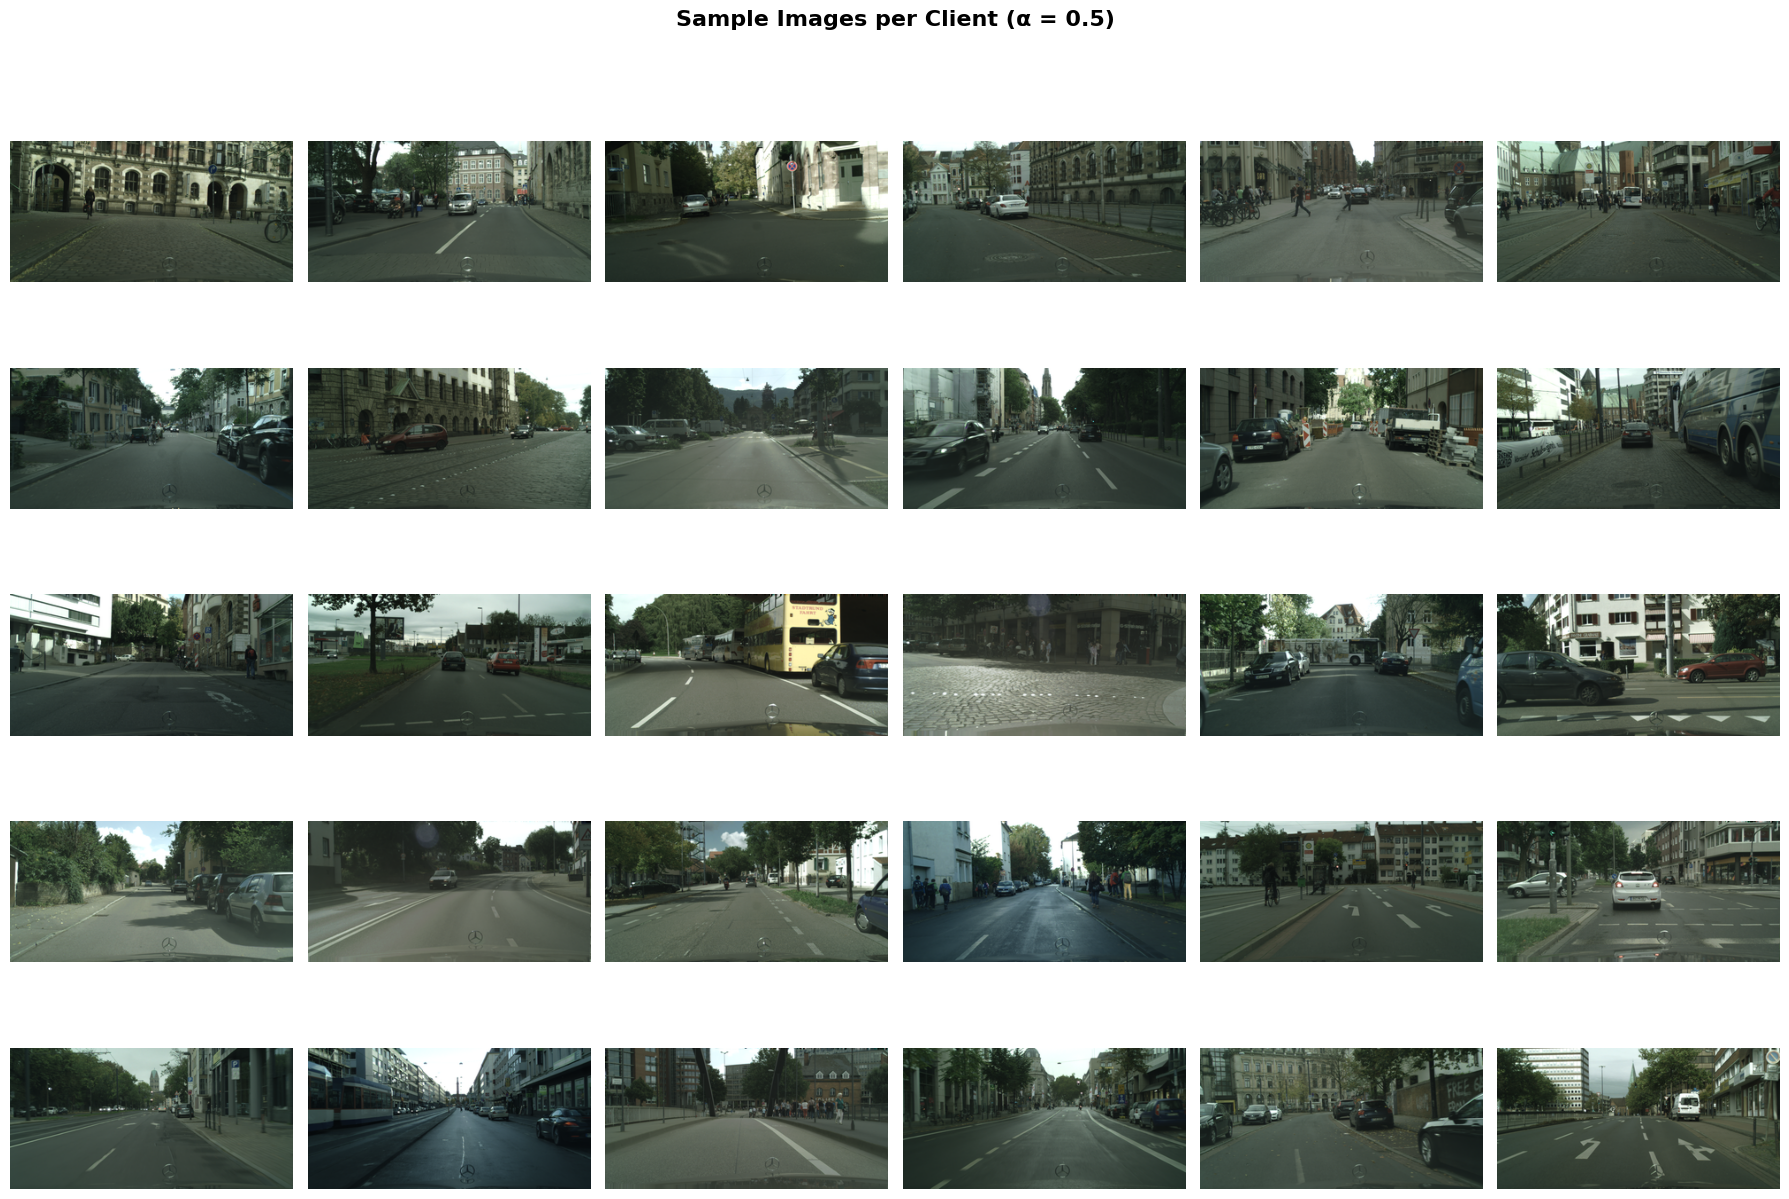


📊 INTERPRETATION:
   • Each row shows images from ONE client
   • With low α (non-IID): clients should have visually similar images
   • With high α (IID): clients should have diverse images
   • Current α = 0.5


In [16]:
# ============================================================
# VISUALIZATION 7: Sample Images per Client
# ============================================================
# See actual images that each client will train on

n_samples_show = 6
n_clients_show = min(n_clients, 5)  # Show first 5 clients

fig, axes = plt.subplots(n_clients_show, n_samples_show, figsize=(18, n_clients_show * 2.5))

for cid in range(n_clients_show):
    client_indices = client_data[cid]
    sample_indices = client_indices[:n_samples_show]
    
    for j, idx in enumerate(sample_indices):
        img = load_image(image_paths[idx])
        axes[cid, j].imshow(img)
        axes[cid, j].axis('off')
    
    # Label on left
    axes[cid, 0].set_ylabel(
        f"Client {cid}\n({len(client_indices)} imgs)",
        fontsize=11, rotation=0, ha='right', va='center', labelpad=60,
        fontweight='bold'
    )

fig.suptitle(f"Sample Images per Client (α = {alpha})", fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/viz7_client_samples.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("   • Each row shows images from ONE client")
print("   • With low α (non-IID): clients should have visually similar images")
print("   • With high α (IID): clients should have diverse images")
print(f"   • Current α = {alpha}")

---

## Section 4: Alpha Comparison Study

**Purpose:** Compare how different Dirichlet α values affect data heterogeneity.

This is crucial for FL research - you need to understand how to control heterogeneity to study its effects on model convergence and performance.

In [17]:
# ============================================================
# Generate partitions with different alpha values
# ============================================================

alpha_values = [0.1, 0.5, 1.0, 10.0, 100.0]

print("Generating partitions with different α values...")
for alpha_val in alpha_values:
    output_name = f"client_splits_alpha_{alpha_val}.pth"
    !python -m dinov2.fl.scripts.run_partitioning \
        --output_dir {OUTPUT_DIR} \
        --n_clients 10 \
        --alpha {alpha_val} \
        --seed 42 2>/dev/null
    
    # Rename output
    !mv {OUTPUT_DIR}/client_splits.pth {OUTPUT_DIR}/{output_name}
    print(f"  ✓ α = {alpha_val}")

print("\n✓ All partitions generated")

Generating partitions with different α values...
Phase 3: Dirichlet Data Partitioning
Clusters: /kaggle/working/fl_outputs/clusters.pth
Number of clients: 10
Alpha (heterogeneity): 0.1
  - Low alpha (0.1): Highly non-IID
  - High alpha (100): Nearly IID
Output: /kaggle/working/fl_outputs/client_splits.pth
Loaded 2975 cluster assignments (16 clusters)
Partitioning 2975 samples across 10 clients
Alpha (heterogeneity): 0.1 (lower = more non-IID)

Partitioning complete:
  Total samples: 2975
  Samples per client: 12 - 706 (mean: 297.5, std: 177.7)

Saving client splits to /kaggle/working/fl_outputs/client_splits.pth

Partitioning complete!
Created splits for 10 clients
Total samples: 2975
Samples per client:
  Client 0: 209 samples from 6 clusters
  Client 1: 706 samples from 8 clusters
  Client 2: 155 samples from 5 clusters
  Client 3: 334 samples from 5 clusters
  Client 4: 276 samples from 9 clusters
  Client 5: 237 samples from 7 clusters
  Client 6: 421 samples from 6 clusters
  Clie

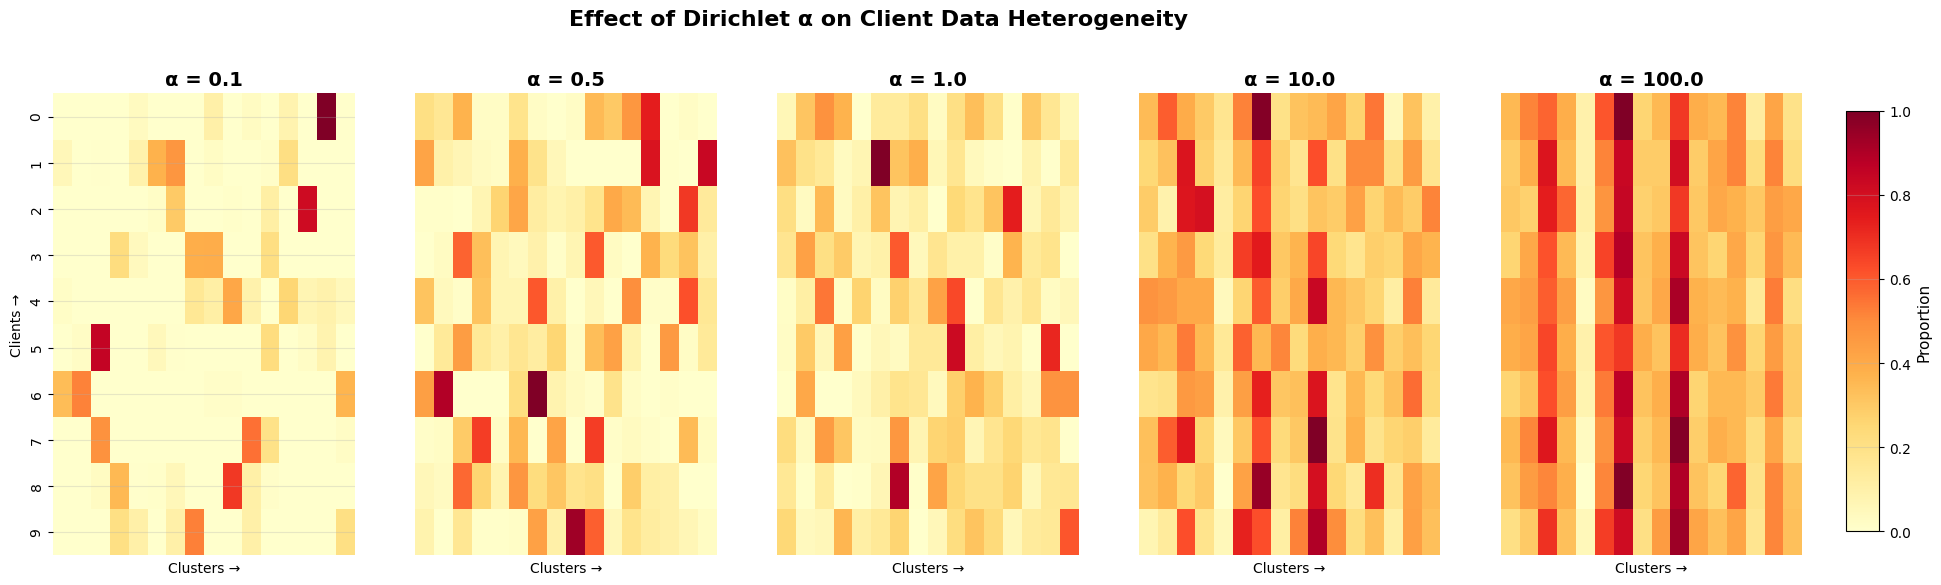


📊 INTERPRETATION:
   ← LEFT (α=0.1): EXTREME NON-IID
       • Each client has data from only 1-2 clusters
       • Clients are highly specialized
       • FL will struggle to converge

   → RIGHT (α=100): NEAR IID
       • Each client has data from many clusters
       • Uniform rows = similar distributions
       • FL should converge easily


In [18]:
# ============================================================
# VISUALIZATION 8: Alpha Comparison - Client-Cluster Heatmaps
# ============================================================
# Side-by-side comparison showing how α affects heterogeneity

fig, axes = plt.subplots(1, 5, figsize=(22, 6))

for i, alpha_val in enumerate(alpha_values):
    splits = torch.load(f"{OUTPUT_DIR}/client_splits_alpha_{alpha_val}.pth")
    client_data_temp = splits["client_data"]
    
    # Build matrix
    matrix = np.zeros((n_clients, n_clusters))
    for cid in range(n_clients):
        for idx in client_data_temp[cid]:
            matrix[cid, cluster_labels[idx]] += 1
    
    # Normalize
    matrix_norm = matrix / matrix.sum(axis=1, keepdims=True)
    
    # Heatmap
    sns.heatmap(
        matrix_norm, 
        cmap='YlOrRd', 
        ax=axes[i],
        cbar=False,
        xticklabels=False,
        yticklabels=[str(j) for j in range(n_clients)] if i == 0 else False
    )
    
    axes[i].set_title(f"α = {alpha_val}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Clusters →", fontsize=10)
    if i == 0:
        axes[i].set_ylabel("Clients →", fontsize=10)

# Add colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.015, 0.7])
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(0, 1))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Proportion', fontsize=11)

fig.suptitle("Effect of Dirichlet α on Client Data Heterogeneity", 
             fontsize=16, fontweight='bold', y=1.02)
plt.savefig(f"{OUTPUT_DIR}/viz8_alpha_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("   ← LEFT (α=0.1): EXTREME NON-IID")
print("       • Each client has data from only 1-2 clusters")
print("       • Clients are highly specialized")
print("       • FL will struggle to converge")
print("")
print("   → RIGHT (α=100): NEAR IID")
print("       • Each client has data from many clusters")
print("       • Uniform rows = similar distributions")
print("       • FL should converge easily")

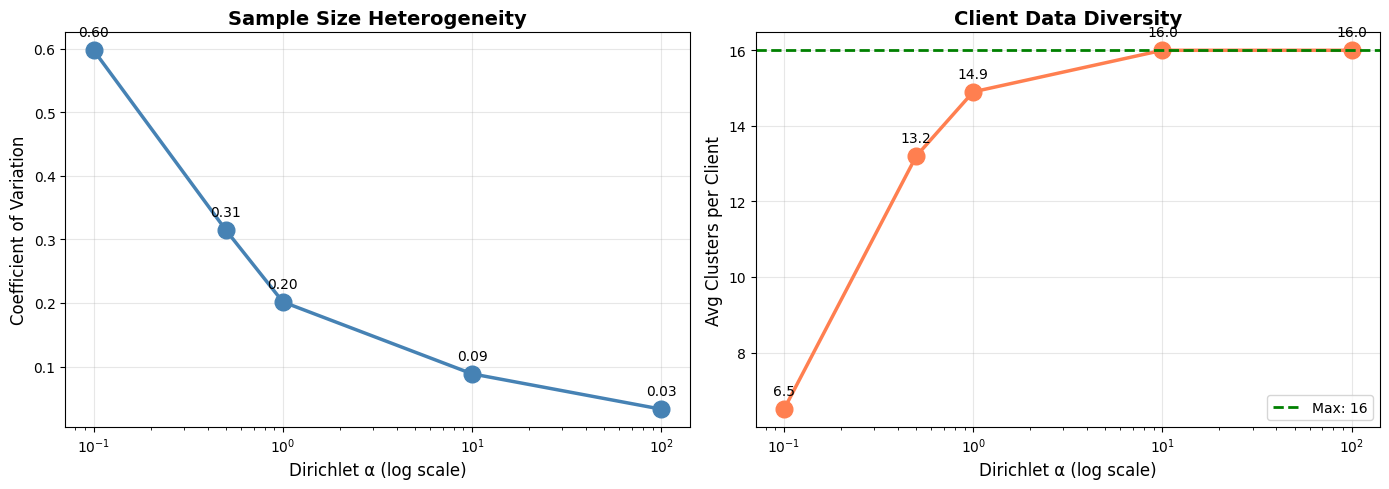


📊 INTERPRETATION:
   LEFT: Coefficient of Variation (CV) of sample sizes
       • Higher CV = more unequal sample distribution
       • Decreases as α increases

   RIGHT: Average number of clusters per client
       • Lower = clients are specialized (non-IID)
       • Approaches max as α increases (IID)


In [19]:
# ============================================================
# VISUALIZATION 9: Quantitative Heterogeneity Metrics
# ============================================================

results = []
for alpha_val in alpha_values:
    splits = torch.load(f"{OUTPUT_DIR}/client_splits_alpha_{alpha_val}.pth")
    stats = splits["statistics"]
    
    samples = [stats['samples_per_client'][i] for i in range(n_clients)]
    clusters = [stats['clusters_per_client'][i] for i in range(n_clients)]
    
    results.append({
        'alpha': alpha_val,
        'sample_std': np.std(samples),
        'sample_cv': np.std(samples) / np.mean(samples),  # Coefficient of variation
        'avg_clusters': np.mean(clusters),
        'min_clusters': min(clusters),
        'max_clusters': max(clusters)
    })

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas = [r['alpha'] for r in results]

# Left: Sample size heterogeneity
cvs = [r['sample_cv'] for r in results]
axes[0].plot(alphas, cvs, 'o-', color='steelblue', linewidth=2.5, markersize=12)
axes[0].set_xscale('log')
axes[0].set_xlabel("Dirichlet α (log scale)", fontsize=12)
axes[0].set_ylabel("Coefficient of Variation", fontsize=12)
axes[0].set_title("Sample Size Heterogeneity", fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add annotations
for a, cv in zip(alphas, cvs):
    axes[0].annotate(f'{cv:.2f}', (a, cv), textcoords="offset points", 
                     xytext=(0, 10), ha='center', fontsize=10)

# Right: Cluster diversity
avg_clusters = [r['avg_clusters'] for r in results]
axes[1].plot(alphas, avg_clusters, 'o-', color='coral', linewidth=2.5, markersize=12)
axes[1].axhline(y=n_clusters, color='green', linestyle='--', linewidth=2, 
                label=f'Max: {n_clusters}')
axes[1].set_xscale('log')
axes[1].set_xlabel("Dirichlet α (log scale)", fontsize=12)
axes[1].set_ylabel("Avg Clusters per Client", fontsize=12)
axes[1].set_title("Client Data Diversity", fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Add annotations
for a, ac in zip(alphas, avg_clusters):
    axes[1].annotate(f'{ac:.1f}', (a, ac), textcoords="offset points",
                     xytext=(0, 10), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/viz9_heterogeneity_metrics.png", dpi=150)
plt.show()

print("\n📊 INTERPRETATION:")
print("   LEFT: Coefficient of Variation (CV) of sample sizes")
print("       • Higher CV = more unequal sample distribution")
print("       • Decreases as α increases")
print("")
print("   RIGHT: Average number of clusters per client")
print("       • Lower = clients are specialized (non-IID)")
print("       • Approaches max as α increases (IID)")

In [20]:
# ============================================================
# Print Summary Table
# ============================================================

print("=" * 85)
print("HETEROGENEITY METRICS SUMMARY")
print("=" * 85)
print(f"{'Alpha':<10} {'Sample CV':<15} {'Avg Clusters':<18} {'Cluster Range':<18} {'Interpretation':<20}")
print("-" * 85)

interpretations = {
    0.1: "Extreme Non-IID",
    0.5: "High Non-IID", 
    1.0: "Moderate Non-IID",
    10.0: "Low Non-IID",
    100.0: "Near IID"
}

for r in results:
    interp = interpretations.get(r['alpha'], "")
    print(f"{r['alpha']:<10} {r['sample_cv']:<15.3f} {r['avg_clusters']:<18.1f} {r['min_clusters']}-{r['max_clusters']:<16} {interp:<20}")

print("=" * 85)
print("\nKEY TAKEAWAYS:")
print("• Use α < 1 for non-IID experiments (realistic FL scenarios)")
print("• Use α > 10 for near-IID baselines")
print("• α = 0.5 is a common choice for moderate heterogeneity")

HETEROGENEITY METRICS SUMMARY
Alpha      Sample CV       Avg Clusters       Cluster Range      Interpretation      
-------------------------------------------------------------------------------------
0.1        0.597           6.5                4-9                Extreme Non-IID     
0.5        0.315           13.2               10-15               High Non-IID        
1.0        0.202           14.9               13-16               Moderate Non-IID    
10.0       0.089           16.0               16-16               Low Non-IID         
100.0      0.033           16.0               16-16               Near IID            

KEY TAKEAWAYS:
• Use α < 1 for non-IID experiments (realistic FL scenarios)
• Use α > 10 for near-IID baselines
• α = 0.5 is a common choice for moderate heterogeneity


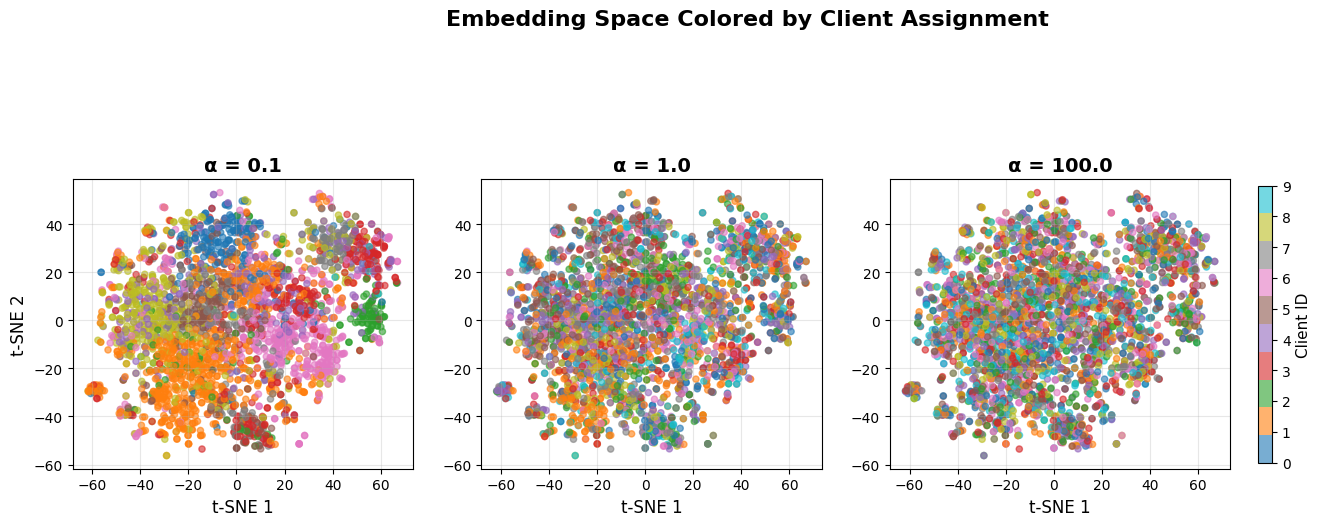


📊 INTERPRETATION:
   α = 0.1 (LEFT): Clients occupy DISTINCT regions
       → Each client gets semantically similar data
       → Strong non-IID pattern

   α = 100 (RIGHT): Clients are MIXED throughout
       → Each client gets diverse data
       → Near-IID pattern


In [21]:
# ============================================================
# VISUALIZATION 10: Embedding Space by Client Assignment
# ============================================================
# Shows how clients "occupy" different regions of embedding space

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
alpha_subset = [0.1, 1.0, 100.0]

for i, alpha_val in enumerate(alpha_subset):
    splits = torch.load(f"{OUTPUT_DIR}/client_splits_alpha_{alpha_val}.pth")
    client_data_temp = splits["client_data"]
    
    # Assign client label to each sample
    sample_to_client = np.zeros(len(embeddings), dtype=int)
    for cid in range(n_clients):
        for idx in client_data_temp[cid]:
            sample_to_client[idx] = cid
    
    scatter = axes[i].scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1],
        c=sample_to_client,
        cmap='tab10',
        alpha=0.6,
        s=20
    )
    
    axes[i].set_title(f"α = {alpha_val}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("t-SNE 1")
    if i == 0:
        axes[i].set_ylabel("t-SNE 2")
    axes[i].set_aspect('equal')

# Add colorbar
cbar = fig.colorbar(scatter, ax=axes, shrink=0.6, pad=0.02)
cbar.set_label('Client ID', fontsize=11)
cbar.set_ticks(range(n_clients))

fig.suptitle("Embedding Space Colored by Client Assignment", 
             fontsize=16, fontweight='bold', y=1.02)
plt.savefig(f"{OUTPUT_DIR}/viz10_embedding_by_client.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 INTERPRETATION:")
print("   α = 0.1 (LEFT): Clients occupy DISTINCT regions")
print("       → Each client gets semantically similar data")
print("       → Strong non-IID pattern")
print("")
print("   α = 100 (RIGHT): Clients are MIXED throughout")
print("       → Each client gets diverse data")
print("       → Near-IID pattern")

---

## Section 5: Output Summary & Export

In [22]:
# ============================================================
# LIST ALL OUTPUTS
# ============================================================

print("=" * 70)
print("GENERATED FILES")
print("=" * 70)

print("\n📁 DATA FILES (for FL training):")
for f in sorted(os.listdir(OUTPUT_DIR)):
    if f.endswith('.pth'):
        fpath = os.path.join(OUTPUT_DIR, f)
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"   {f:<40} {size_mb:.2f} MB")

print("\n📊 VISUALIZATION FILES:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    if f.endswith('.png'):
        print(f"   {f}")

print("=" * 70)

GENERATED FILES

📁 DATA FILES (for FL training):
   client_splits_alpha_0.1.pth              0.33 MB
   client_splits_alpha_0.5.pth              0.33 MB
   client_splits_alpha_1.0.pth              0.33 MB
   client_splits_alpha_10.0.pth             0.33 MB
   client_splits_alpha_100.0.pth            0.33 MB
   clusters.pth                             0.43 MB
   embeddings.pth                           11.95 MB

📊 VISUALIZATION FILES:
   viz10_embedding_by_client.png
   viz1_tsne_by_city.png
   viz2_tsne_by_cluster.png
   viz3_cluster_sizes.png
   viz4_cluster_samples.png
   viz5_client_overview.png
   viz6_client_cluster_heatmap.png
   viz7_client_samples.png
   viz8_alpha_comparison.png
   viz9_heterogeneity_metrics.png


# ============================================================
# ZIP FOR DOWNLOAD
# ============================================================

!cd /kaggle/working && zip -r fl_outputs_complete.zip fl_outputs/

print("\n" + "=" * 70)
print("✅ PIPELINE COMPLETE")
print("=" * 70)
print("Download: /kaggle/working/fl_outputs_complete.zip")
print("Contains all data files and visualizations")
print("=" * 70)